In [199]:
import os
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

In [200]:
!gdown --id '150T5wGQmXNrchuxyl77VxtF47PJEAFlF' --output train.csv
!gdown --id '1fhK6oNlWDh-pDVz9jqraInWg7w0ZeMoz' --output test.csv
!gdown --id '1Opd52gj6UEYaIocC38IzFWJqQG5_p5r9' --output gender_submission.csv
!ls

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=150T5wGQmXNrchuxyl77VxtF47PJEAFlF
To: /content/train.csv
100% 61.2k/61.2k [00:00<00:00, 58.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fhK6oNlWDh-pDVz9jqraInWg7w0ZeMoz
To: /content/test.csv
100% 28.6k/28.6k [00:00<00:00, 35.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://

In [201]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [202]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [203]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [204]:
modes = df_train.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [205]:
df_train.fillna(modes, inplace=True)

In [206]:
df_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [207]:
df_train.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


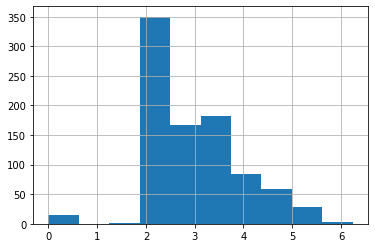

In [208]:
df_train['LogFare'] = np.log(df_train['Fare']+1)
df_train['LogFare'].hist()

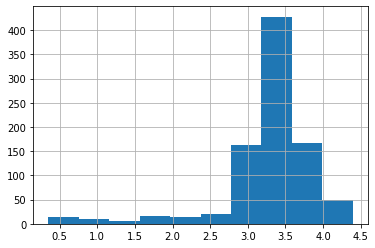

In [209]:
df_train['LogAge'] = np.log(df_train['Age']+1)
df_train['LogAge'].hist()

In [210]:
df_train.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [211]:
df_train = pd.get_dummies(df_train, columns=['Sex', 'Pclass', 'Embarked'])

In [212]:
df_train = df_train.select_dtypes(np.number)
columns = df_train.columns
corr = np.where(df_train.corr("pearson").iloc[1] > 0.)
print(list(columns[corr]))

['Survived', 'Parch', 'Fare', 'LogFare', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_Q']


In [213]:
ts_survived = torch.tensor(df_train.Survived)

In [214]:
scaler = MinMaxScaler()
cols = ['Parch', 'Fare', 'LogFare', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_Q']
df_train[cols] = scaler.fit_transform(df_train[cols])
ts_cols = torch.tensor(df_train[cols].values, dtype = torch.float)
ts_cols

tensor([[0.0000, 0.0142, 0.3381,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1391, 0.6859,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0155, 0.3507,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3333, 0.0458, 0.5122,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0586, 0.5502,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0151, 0.3476,  ..., 0.0000, 0.0000, 1.0000]])

In [215]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False
same_seeds(65)

In [216]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc_layer = nn.Sequential(
        nn.Linear(ts_cols.shape[1], 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 2)
    )
    def forward(self, x):
        output = self.fc_layer(x)
        return output

In [217]:
class TrainDataset(Dataset):
    def __init__(self, data, label, mode):
        self.data = data
        self.label = label
        self.mode = mode
    def __getitem__(self, idx):
        if self.mode == 'train' or self.mode == 'valid':
              return self.data[idx], self.label[idx]
        else:
              return self.data[idx]
    def __len__(self):
        return len(self.data)

In [218]:
BATCH_SIZE = 4
EPOCHS = 300
LR = 1e-3

def split_dataset():
    train_idx = random.sample(range(0,ts_cols.shape[0] - 1), 750)
    valid_idx = [idx for idx in range(ts_cols.shape[0]) if idx not in train_idx]
    print(f'Train Samples Num = {len(train_idx)}')
    print(f'Vaild Samples Num = {len(valid_idx)}')
    
    train_data = ts_cols[train_idx]
    train_label = ts_survived[train_idx]
    
    print(f'Train Data Shape = {train_data.shape}')
    
    valid_data = ts_cols[valid_idx]
    valid_label = ts_survived[valid_idx]
    
    print(f'Valid Data Shape = {valid_data.shape}')
    
    train_dataset = TrainDataset(train_data, train_label, mode = 'train')
    valid_dataset = TrainDataset(valid_data, valid_label, mode = 'valid')
    
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
    valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)
    
    return train_loader, valid_loader

In [219]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

early_stop = 30
loss_fn = nn.CrossEntropyLoss()
model_paths = []
os.makedirs('models', exist_ok = True)

stop_count = 0
best_acc = 0.0
model = LinearModel().to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr = LR)
model_path = f'models/linear.ckpt'
model_paths.append(model_path)
train_loader, valid_loader = split_dataset()
for epochs in range(EPOCHS):
  model.train()
  total = 0
  correct = 0
  train_loss = []
  for idx, batch in enumerate(tqdm(train_loader)):
    datas, labels = batch
    datas = datas.to(device)
    labels = labels.to(device)
            
    logits = model(datas)
            
    loss = loss_fn(logits, labels)
            
    preds = torch.argmax(logits, dim=-1)
    total += labels.shape[0]
    correct += (preds==labels).sum().item()
            
    loss.backward()
    train_loss.append(loss.item())
            
    optimizer.step()
    optimizer.zero_grad()
  train_acc = correct / total
  train_loss = sum(train_loss) / len(train_loss)
  print(f'[Epochs = {epochs}] train Accuracy = {train_acc:.5f}, train Loss = {train_loss:.5f}')
        
  model.eval()
        
  total = 0
  correct = 0
  valid_loss = []
  for idx, batch in enumerate(tqdm(valid_loader)):
      datas, labels = batch
      datas = datas.to(device)
      labels = labels.to(device)
            
      logits = model(datas)
            
      loss = loss_fn(logits, labels)
            
      preds = torch.argmax(logits, dim=-1)
      total += labels.shape[0]
      correct += (preds==labels).sum().item()
            
      loss.backward()
      valid_loss.append(loss.item())
            
      optimizer.step()
      optimizer.zero_grad()
  valid_acc = correct / total
  valid_loss = sum(valid_loss) / len(valid_loss)
  print(f'[Epochs = {epochs}] Valid Accuracy = {valid_acc:.5f}, Valid Loss = {valid_loss:.5f}')
  if valid_acc >= best_acc:
      best_acc = valid_acc
      torch.save(model.state_dict(), model_path)
      print(f'Save model with accuracy = {best_acc:.5f}')
      stop_count = 0
  else:
      stop_count +=1
      if stop_count > early_stop:
          print("Eraly Stop!")
          break
model1 = LinearModel().to(device)
model1.load_state_dict(torch.load(model_paths[0]))
model1.eval()

models = [model1]

Train Samples Num = 750
Vaild Samples Num = 141
Train Data Shape = torch.Size([750, 8])
Valid Data Shape = torch.Size([141, 8])


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 0] train Accuracy = 0.65241, train Loss = 0.63887


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 0] Valid Accuracy = 0.78014, Valid Loss = 0.51675
Save model with accuracy = 0.78014


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 1] train Accuracy = 0.74064, train Loss = 0.55791


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 1] Valid Accuracy = 0.80142, Valid Loss = 0.50159
Save model with accuracy = 0.80142


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 2] train Accuracy = 0.72594, train Loss = 0.56583


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 2] Valid Accuracy = 0.78723, Valid Loss = 0.50392


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 3] train Accuracy = 0.73663, train Loss = 0.57460


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 3] Valid Accuracy = 0.80851, Valid Loss = 0.46858
Save model with accuracy = 0.80851


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 4] train Accuracy = 0.72861, train Loss = 0.55965


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 4] Valid Accuracy = 0.80851, Valid Loss = 0.48322
Save model with accuracy = 0.80851


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 5] train Accuracy = 0.73128, train Loss = 0.56428


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 5] Valid Accuracy = 0.80851, Valid Loss = 0.47792
Save model with accuracy = 0.80851


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 6] train Accuracy = 0.74064, train Loss = 0.55926


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 6] Valid Accuracy = 0.79433, Valid Loss = 0.47882


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 7] train Accuracy = 0.73663, train Loss = 0.56146


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 7] Valid Accuracy = 0.79433, Valid Loss = 0.46878


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 8] train Accuracy = 0.73396, train Loss = 0.55854


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 8] Valid Accuracy = 0.78723, Valid Loss = 0.48794


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 9] train Accuracy = 0.72460, train Loss = 0.55168


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 9] Valid Accuracy = 0.78723, Valid Loss = 0.47348


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 10] train Accuracy = 0.74599, train Loss = 0.54754


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 10] Valid Accuracy = 0.78723, Valid Loss = 0.47471


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 11] train Accuracy = 0.77139, train Loss = 0.51636


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 11] Valid Accuracy = 0.80142, Valid Loss = 0.45635


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 12] train Accuracy = 0.74465, train Loss = 0.55457


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 12] Valid Accuracy = 0.80142, Valid Loss = 0.47732


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 13] train Accuracy = 0.73797, train Loss = 0.56172


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 13] Valid Accuracy = 0.79433, Valid Loss = 0.46661


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 14] train Accuracy = 0.75936, train Loss = 0.53555


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 14] Valid Accuracy = 0.78723, Valid Loss = 0.49169


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 15] train Accuracy = 0.76337, train Loss = 0.54094


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 15] Valid Accuracy = 0.78723, Valid Loss = 0.48871


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 16] train Accuracy = 0.75802, train Loss = 0.52821


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 16] Valid Accuracy = 0.80142, Valid Loss = 0.46573


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 17] train Accuracy = 0.74866, train Loss = 0.55729


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 17] Valid Accuracy = 0.79433, Valid Loss = 0.47352


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 18] train Accuracy = 0.75401, train Loss = 0.54567


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 18] Valid Accuracy = 0.79433, Valid Loss = 0.47036


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 19] train Accuracy = 0.74866, train Loss = 0.53801


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 19] Valid Accuracy = 0.78723, Valid Loss = 0.47713


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 20] train Accuracy = 0.74733, train Loss = 0.57884


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 20] Valid Accuracy = 0.78723, Valid Loss = 0.47805


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 21] train Accuracy = 0.76337, train Loss = 0.53847


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 21] Valid Accuracy = 0.78723, Valid Loss = 0.46344


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 22] train Accuracy = 0.75000, train Loss = 0.54519


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 22] Valid Accuracy = 0.78723, Valid Loss = 0.47567


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 23] train Accuracy = 0.75668, train Loss = 0.54803


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 23] Valid Accuracy = 0.79433, Valid Loss = 0.48237


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 24] train Accuracy = 0.75802, train Loss = 0.53996


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 24] Valid Accuracy = 0.78014, Valid Loss = 0.46129


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 25] train Accuracy = 0.75535, train Loss = 0.53820


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 25] Valid Accuracy = 0.79433, Valid Loss = 0.46831


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 26] train Accuracy = 0.75802, train Loss = 0.53300


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 26] Valid Accuracy = 0.80142, Valid Loss = 0.46479


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 27] train Accuracy = 0.76203, train Loss = 0.53443


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 27] Valid Accuracy = 0.79433, Valid Loss = 0.44515


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 28] train Accuracy = 0.76070, train Loss = 0.52807


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 28] Valid Accuracy = 0.79433, Valid Loss = 0.47200


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 29] train Accuracy = 0.73930, train Loss = 0.54618


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 29] Valid Accuracy = 0.78723, Valid Loss = 0.44743


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 30] train Accuracy = 0.75401, train Loss = 0.52395


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 30] Valid Accuracy = 0.79433, Valid Loss = 0.47053


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 31] train Accuracy = 0.76471, train Loss = 0.52672


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 31] Valid Accuracy = 0.80142, Valid Loss = 0.45970


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 32] train Accuracy = 0.75267, train Loss = 0.55662


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 32] Valid Accuracy = 0.80142, Valid Loss = 0.45541


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 33] train Accuracy = 0.74866, train Loss = 0.55923


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 33] Valid Accuracy = 0.80142, Valid Loss = 0.45860


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 34] train Accuracy = 0.76337, train Loss = 0.52814


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 34] Valid Accuracy = 0.80142, Valid Loss = 0.46683


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 35] train Accuracy = 0.75000, train Loss = 0.55524


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 35] Valid Accuracy = 0.80142, Valid Loss = 0.47836


  0%|          | 0/187 [00:00<?, ?it/s]

[Epochs = 36] train Accuracy = 0.75535, train Loss = 0.54838


  0%|          | 0/36 [00:00<?, ?it/s]

[Epochs = 36] Valid Accuracy = 0.78723, Valid Loss = 0.46959
Eraly Stop!


In [220]:
df_test = pd.get_dummies(df_test, columns=['Sex', 'Pclass', 'Embarked'])

In [221]:
test_idx = df_test['PassengerId']

In [222]:
df_test['LogFare'] = np.log(df_test['Fare']+1)

In [223]:
df_test['LogAge'] = np.log(df_test['Age']+1)

In [224]:
scaler = MinMaxScaler()
cols = ['Parch', 'Fare', 'LogFare', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_Q']
df_test[cols] = scaler.fit_transform(df_test[cols])
ts_test_cols = torch.tensor(df_test[cols].values, dtype = torch.float)
ts_test_cols

tensor([[0.0000, 0.0153, 0.3490,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0137, 0.3332,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0189, 0.3796,  ..., 1.0000, 0.0000, 1.0000],
        ...,
        [0.0000, 0.0142, 0.3381,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0157, 0.3530,  ..., 0.0000, 0.0000, 0.0000],
        [0.1111, 0.0436, 0.5049,  ..., 0.0000, 1.0000, 0.0000]])

In [225]:
test_dataset = TrainDataset(ts_test_cols, label = None, mode = 'test')
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [226]:
pred_result = []
for idx, batch in enumerate(tqdm(test_loader)):
    datas = batch
    datas = datas.to(device)
    
    for idx, model in enumerate(models):
        if idx ==0:
            logits = model(datas)
        else:
            logits+=model(datas)
    preds = torch.argmax(logits, dim=-1)
    pred_result += list(preds)

    
    with open('pred_ensembles.csv','w') as f:
        f.write('PassengerId,Survived\n')
        for idx, pred in zip(test_idx, pred_result):
            preds = pred.item()
            f.write(f'{idx},{preds}\n')
print('End of Training')


  0%|          | 0/105 [00:00<?, ?it/s]

End of Training
